In [2]:
import zipfile, io
import os
import re
import glob

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def moving_average(data, window):
    padding_num = int(np.floor(window / 2))
    start_padding = data[:padding_num].mean().repeat(padding_num)
    end_padding = data[len(data)-padding_num:].mean().repeat(padding_num)

    values = np.concatenate([start_padding, data, end_padding])

    ret = np.cumsum(values, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window


class MovingAverager:
    def __init__(self, windows):
        if isinstance(windows, List):
            self.windows = windows
        elif isinstance(windows, int):
            self.windows = [windows]
        self.max_window = max(self.windows)
    
    def execute(self, data):
        assert len(data) >= self.max_window
        
        result = np.zeros(len(data))

        for window in self.windows:
            result += moving_average(data=data, window=window)
        result /= len(self.windows)

        return result

In [4]:
def read_from_folder(folder):
    acc_df = pd.read_csv(os.path.join(folder, 'Accelerometer.csv'))
    lin_acc_df = pd.read_csv(os.path.join(folder, 'Linear Accelerometer.csv'))
    mag_df = pd.read_csv(os.path.join(folder, 'Magnetometer.csv'))
    gyro_df = pd.read_csv(os.path.join(folder, 'Gyroscope.csv'))
    
    total_df = pd.concat([acc_df, gyro_df, lin_acc_df, mag_df], axis=1)
    return total_df


def rename_data(df):
#     new_names = ['acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    new_names = ['times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    return df


def gen_total_mag(df: pd.DataFrame):
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    return df


def smooth(df):
    for column in df.columns:
        if 'time' in column:
            continue
        df[column] = moving_average(df[column], 5)
    return df


def select_data(df):
    return df[['times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t']]


def bound_range(df, datapoint_per_second=20):
    start = int(datapoint_per_second * 1.0)
    end = int(len(df) - datapoint_per_second * 1.0)
    
    return df.iloc[start:end].reset_index(drop=True)


def load_data(folder):
    total_df = read_from_folder(folder)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    
    total_df = gen_total_mag(total_df)
    total_df = smooth(total_df)
    
    total_df = select_data(total_df)
    total_df = bound_range(total_df)
    
    return total_df

In [5]:
all_data = {}

for user_folder in sorted(glob.glob('./R403_trajectory/user*')):
    user = user_folder.split('/')[-1]
    all_data[user] = {}
    
    for path_folder in sorted(glob.glob(os.path.join(user_folder, 'Path*'))):   
        path = path_folder.split('/')[-1]
#         try:
        temp = {}
        for i, posture_folder in enumerate(sorted(glob.glob(os.path.join(path_folder, '*[!zip]')))):
            posture = posture_folder.split('/')[-1]
            
            print(posture_folder)

            df = load_data(posture_folder)
            temp[posture] = df.to_numpy()
                
#         except Exception as e:
#             print(path_folder)
#             print(e)
#             continue
        
        all_data[user][path] = temp

./R403_trajectory/user1/Path1/front_pocket
./R403_trajectory/user1/Path1/horizontal
./R403_trajectory/user1/Path1/pocket
./R403_trajectory/user1/Path1/swing
./R403_trajectory/user1/Path1/target
./R403_trajectory/user1/Path2/front_pocket
./R403_trajectory/user1/Path2/horizontal
./R403_trajectory/user1/Path2/pocket
./R403_trajectory/user1/Path2/swing
./R403_trajectory/user1/Path2/target
./R403_trajectory/user1/Path4/front_pocket
./R403_trajectory/user1/Path4/horizontal
./R403_trajectory/user1/Path4/pocket
./R403_trajectory/user1/Path4/swing
./R403_trajectory/user1/Path4/target
./R403_trajectory/user1/Path5/front_pocket
./R403_trajectory/user1/Path5/horizontal
./R403_trajectory/user1/Path5/pocket
./R403_trajectory/user1/Path5/swing
./R403_trajectory/user1/Path5/target
./R403_trajectory/user2/Path1/front_pocket
./R403_trajectory/user2/Path1/horizontal
./R403_trajectory/user2/Path1/pocket
./R403_trajectory/user2/Path1/swing
./R403_trajectory/user2/Path1/target
./R403_trajectory/user2/Path2/

In [6]:
def read_data(path):
    data = []
    
    for file_path in glob.glob(f'{path}/**/Magnetometer.csv', recursive=True):
        df = pd.read_csv(file_path, delimiter='\t')
        cord = file_path.split('/')[-2].split('_')[2:]
        cord = (float(cord[0]), float(cord[1]))
        
        mean_mag = df[["X (µT)", "Y (µT)", "Z (µT)"]].mean().to_numpy()
#         data.append(np.concatenate((cord, mean_mag)))
        data.append(np.concatenate((cord, mean_mag)))
        
    return np.array(data)

# grid_data = read_data('/root/Calibration/PhyPhox/Grid/')
# grid_data[:, :2] = grid_data[:, :2] - np.array((1, 1))
# grid_data = grid_data[np.lexsort((grid_data[:, 1], grid_data[:, 0]))]
# grid_data.shape

In [7]:
grids = []
grid_dict = {}
        
for folder in sorted(os.listdir('./R403_grids/')):
    if os.path.isfile(f'./R403_grids/{folder}') or folder.startswith('_') or folder.startswith('.'):
        continue
    print(folder)
    
    for name in sorted(os.listdir(f'./R403_grids/{folder}/')):
        if name.endswith('.zip') and not name.startswith('__'):
            cord = name[:-4].split('-')[-2:]
            cord = np.array([float(cord[0]), float(cord[1])])

            path = f'./R403_grids/{folder}/{name}'
            with zipfile.ZipFile(path, 'r') as sub_zipfile:

                with sub_zipfile.open('Raw Data.csv', 'r') as csv_file:
                    df = pd.read_csv(csv_file, delimiter=',')

                    row = df.mean()
                    row['cord_x'] = cord[1]
                    row['cord_y'] = cord[0]

                    point = row[['cord_y', 'cord_x', 'Magnetic Field x (µT)', 'Magnetic Field y (µT)', 'Magnetic Field z (µT)', 'Absolute field (µT)']].to_numpy()
                    grids.append(point)
                    grid_dict[(cord[1], cord[0])] = row[['Magnetic Field x (µT)', 'Magnetic Field y (µT)', 'Magnetic Field z (µT)', 'Absolute field (µT)']].to_numpy()

r012
r10111213
r1415161718
r34567
r89
znew
zthree


In [8]:
grids = np.array(grids)
grid_data = grids[np.lexsort((grids[:, 1], grids[:, 0]))]

(636, 6)


(636, 6)

In [9]:
user_path = defaultdict(dict)

for folder in glob.glob('./user_path/*.npy'):
    print(folder)
    user_name = re.search(r'user\d', folder)[0]
    
    paths = np.load(folder, allow_pickle=True)
    
    for i in range(len(paths)):
        user_path[user_name][f'Path{i+1}'] = paths[i]

./user_path/user2_path.npy
./user_path/user1_path.npy
./user_path/user4_path.npy
./user_path/user3_path.npy


[279 258 237 216 195 175 154 133 112  92  71  50  29   9  32  55  78 101
 124 147 170 193 216 239 262 285 308 331 354 377 400 423 446 469 492 515
 538 561 585 564 545 525 505 484 465]


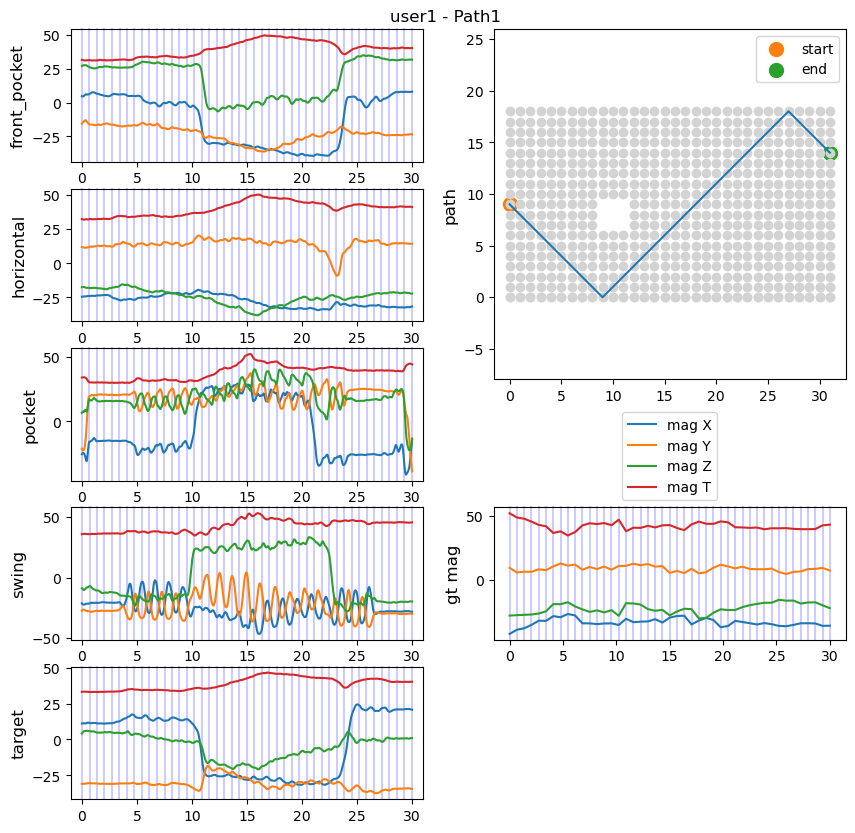

[ 93 115 138 161 184 207 230 253 275 298 321 344 367 390 412 435 458 481
 504 527 550 573 552 531 510 489 468 447 426 406 385 364 343 322 301 280
 259 239 218 197 176 155 134 113  93  71  50  29  28  27  26  25  24  23
  22  21  20  19  18  17  16  15  14  13  12  11  10   9   8   7   6   5
   4   3   2   1   0]


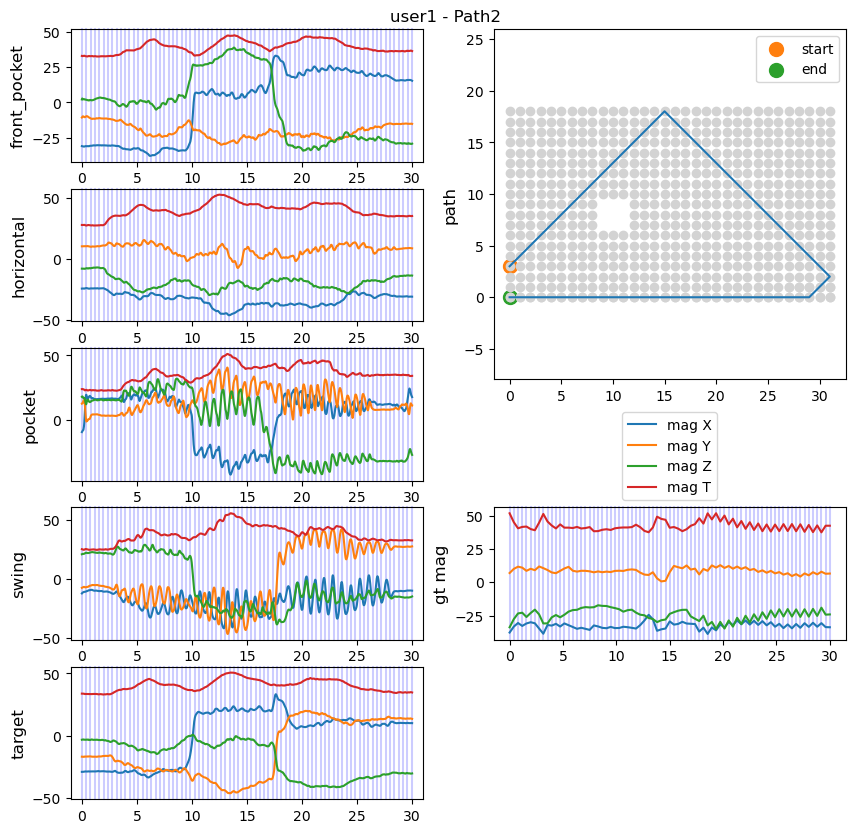

[ 12  43  74 105 136 167 198 229 260 291 322 353 384 415 446 477 508 539
 570 569 568 567 566 565 534 503 472 441 410 379 348 317 286 255 224 193
 162 131 100  69  38   7   6   5   4   3   2  33  64  95 126 157 188 219
 250 281 312 343 374 405 436 467 498 529 560]


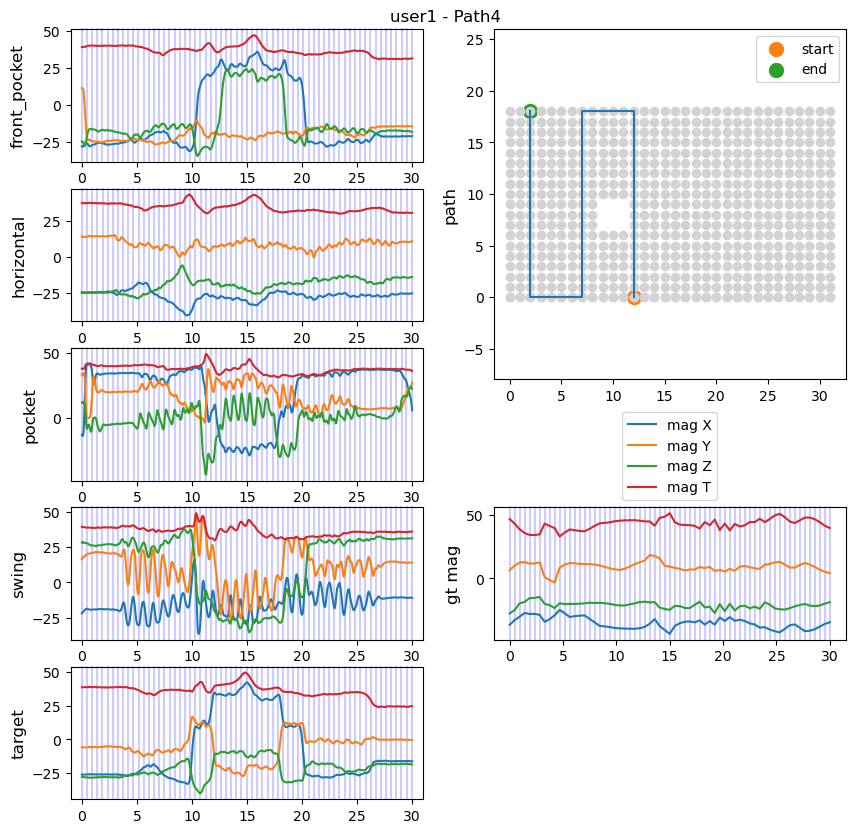

[ 27  58  89 120 151 182 213 244 275 306 337 368 399 430 461 492 523 554
 585 584 583 582 581 580 549 518 487 456 425 394 363 332 301 270 239 208
 177 146 115  84  53  22  21  20  19  18  17  48  79 110 141 172 203 234
 265 296 327 358 389 420 451 482 513 544 575]


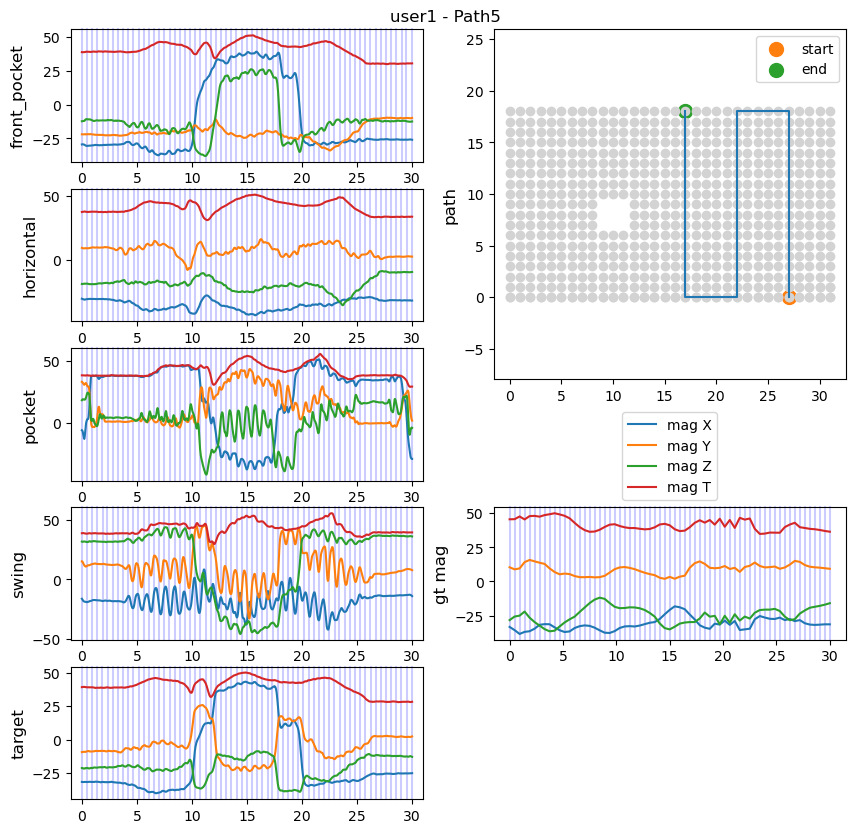

[  0  32  62  94 124 156 186 218 248 280 310 342 372 404 434 466 496 528
 558]


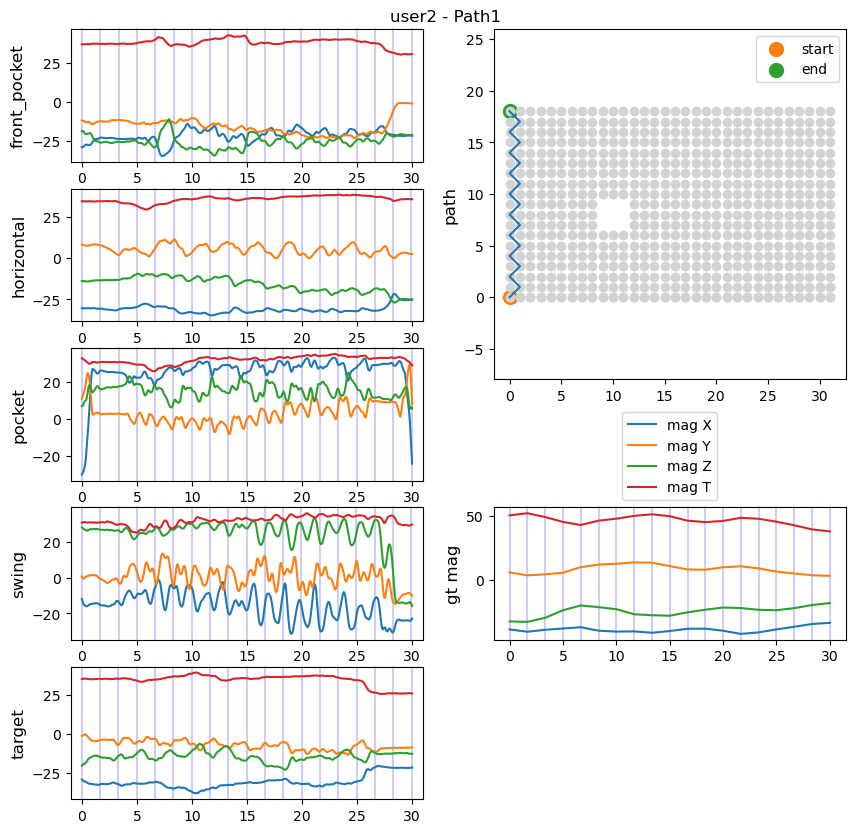

[  0   1   2   3   4  35  66  97 128 159 190 221 252 283 314 345 376 407
 438 469 500 531 562 563 532 501 470 439 408 377 346 315 284 253 222 191
 160 129  98  67  36   5   6   7   8   9]


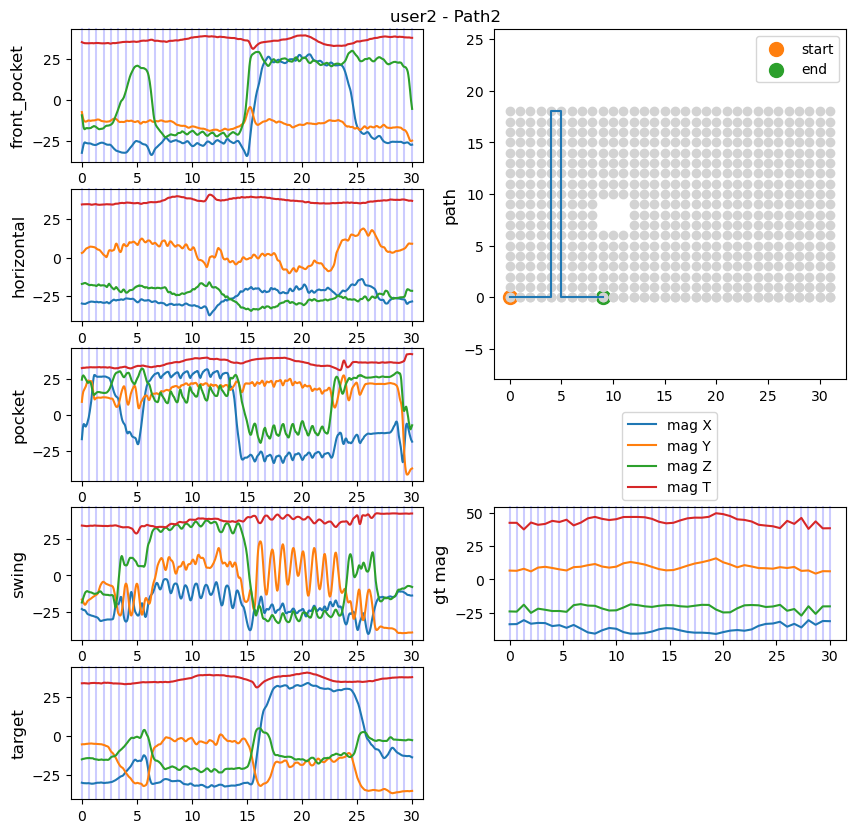

[155 178 201 224 247 270 293 316 339 362 386 409 432 455 478 501 524 547
 571]


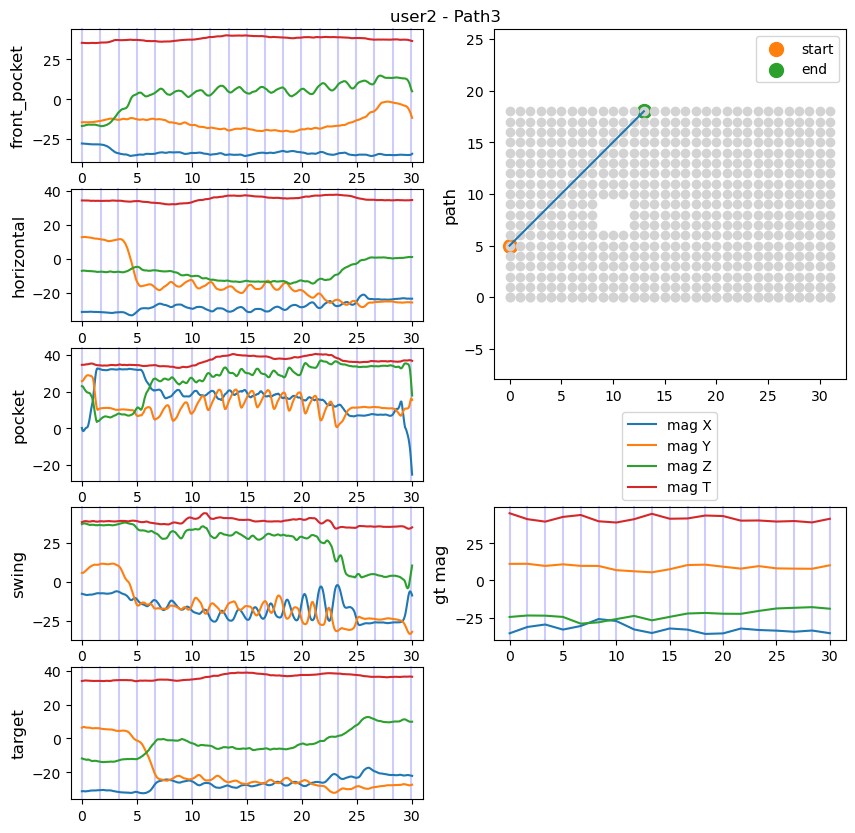

[ 10  41  72 103 134 165 196 197 198 199 200 169 138 107  76  45  14  15
  16  17  18  19  50  81 112 143 174 205 236 267 298 329 360 391 422 453
 484 515 546 577 578 579 580 581 582 551 520 489 458 427 396 365 334 303
 272 241 210 179 148 117  86  55  24]


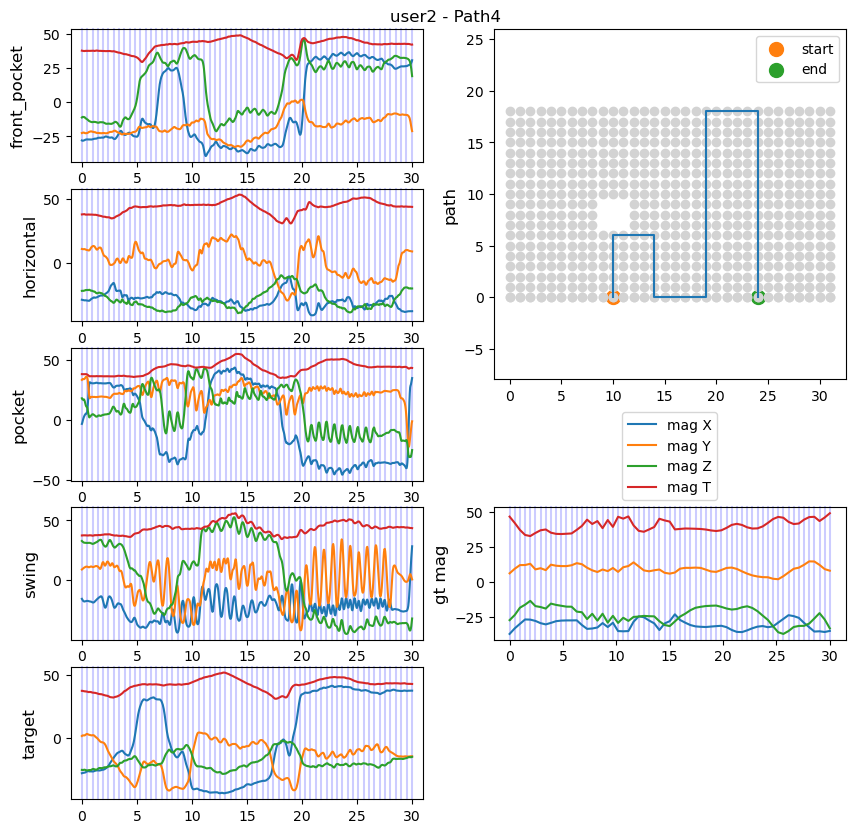

[ 31  62  93 124 155 186 217 248 279 310 341 372 403 434 465 496 527 558
 589 588 557 526 495 464 433 402 371 340 309 278 247 216 185 154 123  92
  61  30  29  60  91 122 153 184 215 246 277 308 339 370 401 432 463 494
 525 556 587 586 555 524 493 462 431 400 369 338 307 276 245 214 183 152
 121  90  59  28  27  58  89 120 151 182 213 244 275 306 337 368 399 430
 461 492 523 554 585 584 553 522 491 460 429 398 367 336 305 274 243 212
 181 150 119  88  57  26]


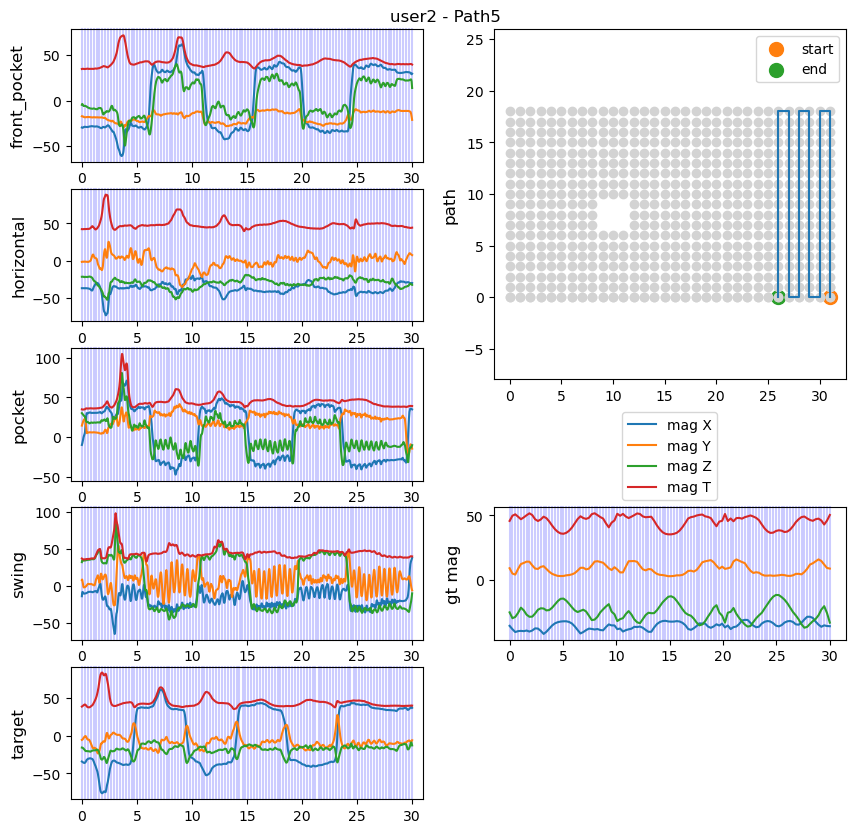

[  5  36  67  98 129 160 191 222 253 284 315 346 377 408 439 470 501 532
 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580
 581 582 583 584 585 586 587 556 525 494 463 432 401 370 339 308 277 246
 215 184 153 122  91  60  29]


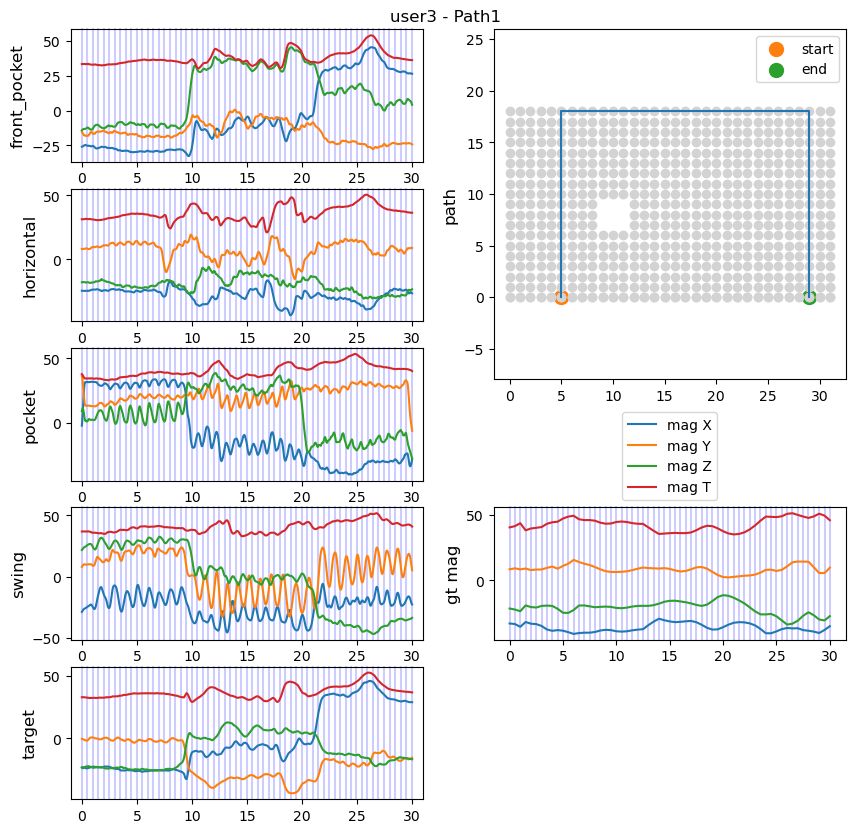

[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 427 396 365 334 303 272 241 210 179 148 117
  86  55  24  23  22  21  20  19  18  17  16  15]


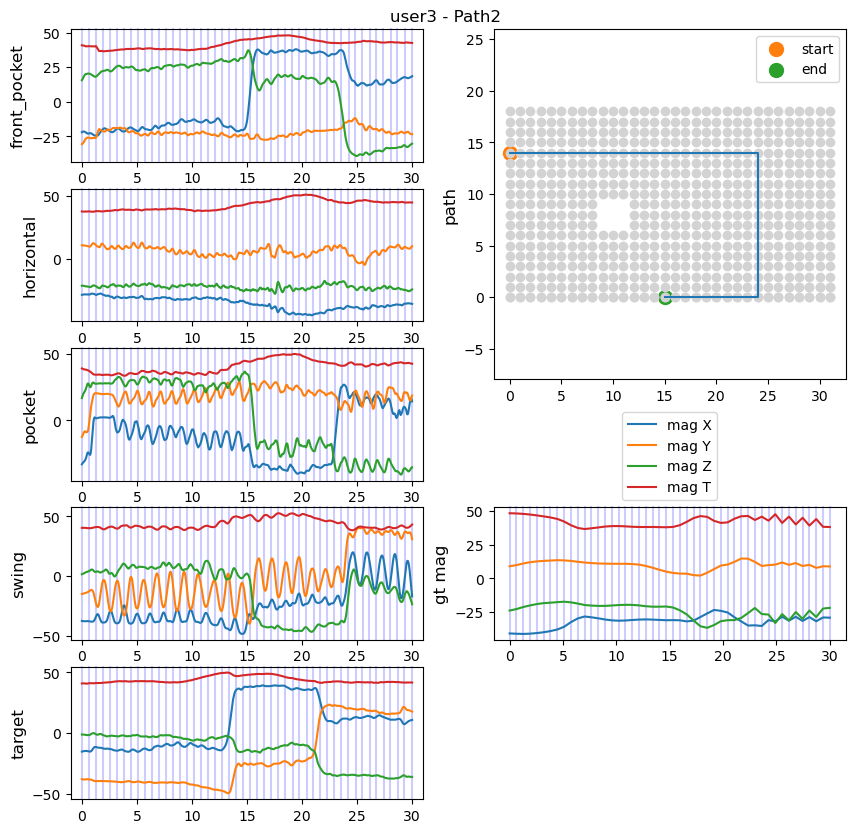

[  0  31  62  93 124 125 126 127 128 159 190 221 252 283 314 345 376 377
 378 379 380 349 318 287 256 225 194 163 132 133 134 135 136 105  74  43
  12  13  14  15  16  47  78 109 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155]


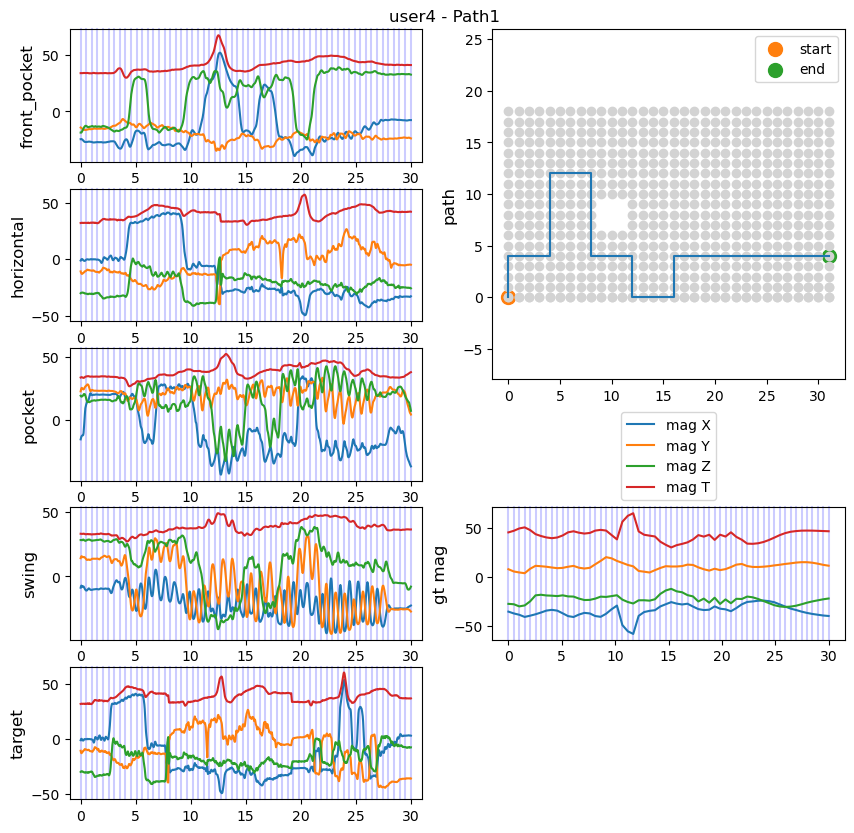

[558 559 560 561 562 542 523 503 484 465 466 467 468 469 488 507 527 546
 566 535 504 473 474 475 476 477 494 512 530 548 566 567 568 569 570 571
 572 573 574 543 512 481 450 419 388 357 356 355 354 353 370 388 406 424
 442 443 444 445 446 415 384 353 322 291 260 229 230 231 262 293 324 355
 386 417 448 479 510 541 572]


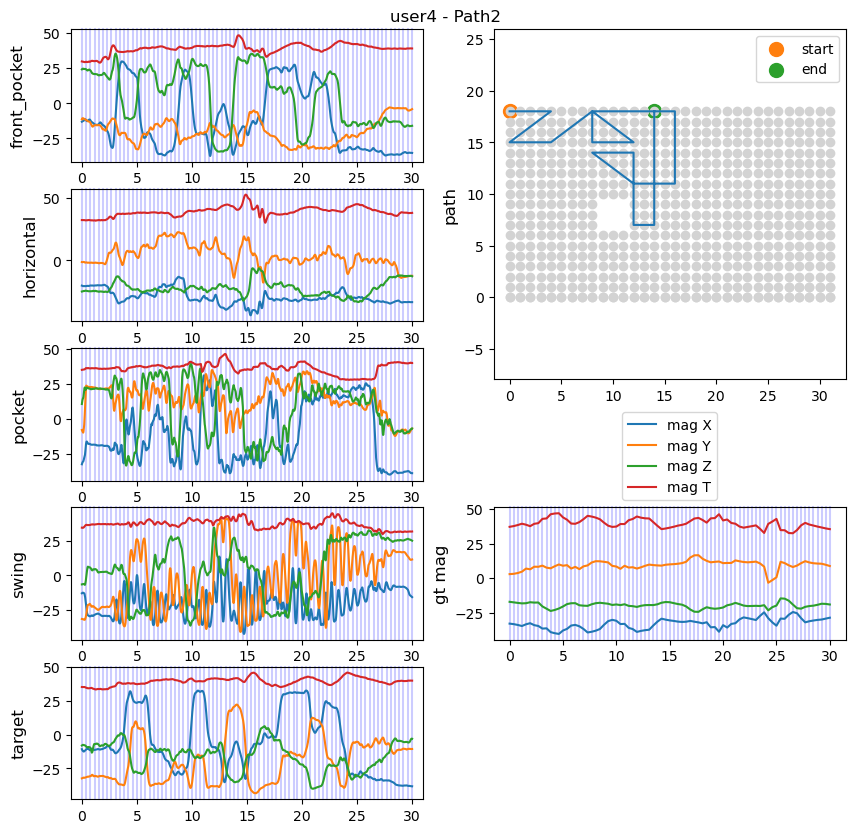

[496 495 494 493 492 523 554 585 584 583 582 581 580 579 578 577 576 575
 544 513 482 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 443 422 401 379 358 337 336 335 334 333 364 395 426 457 488 519 550 549
 548 547 546 515 484 453 422 391 360 361 362 363 364 365 366 367 368 369
 370 371 340 309 278 247 216 217]


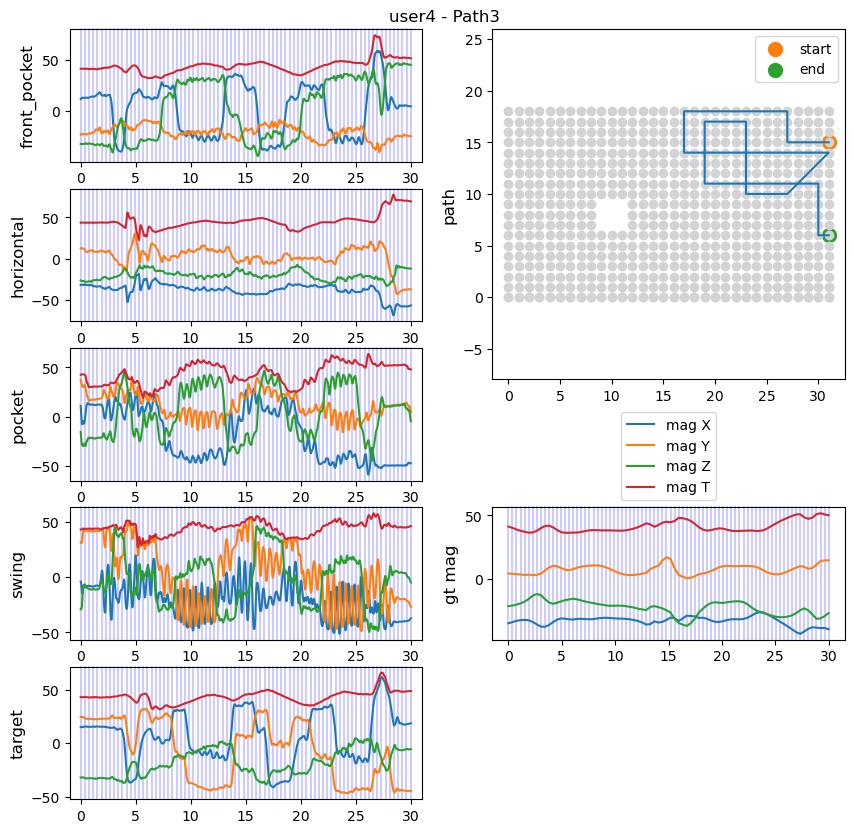

[  6  37  68  99 130 161 160 159 158 157 156 155 186 217 248 279 280 281
 282 283 284 285 254 223 192 193 194 195 196 197 198 199 200 169 138 107
 106 105 104 103 102 101  70  39  40  41  42  43  44  45  46  47  48  49
  50  66  83  99 116  85  54  23  22  21  20  19  18  49  80 111 142 173
 204 205 206 207 208 209 210 211 180 149 118  87  56  25]


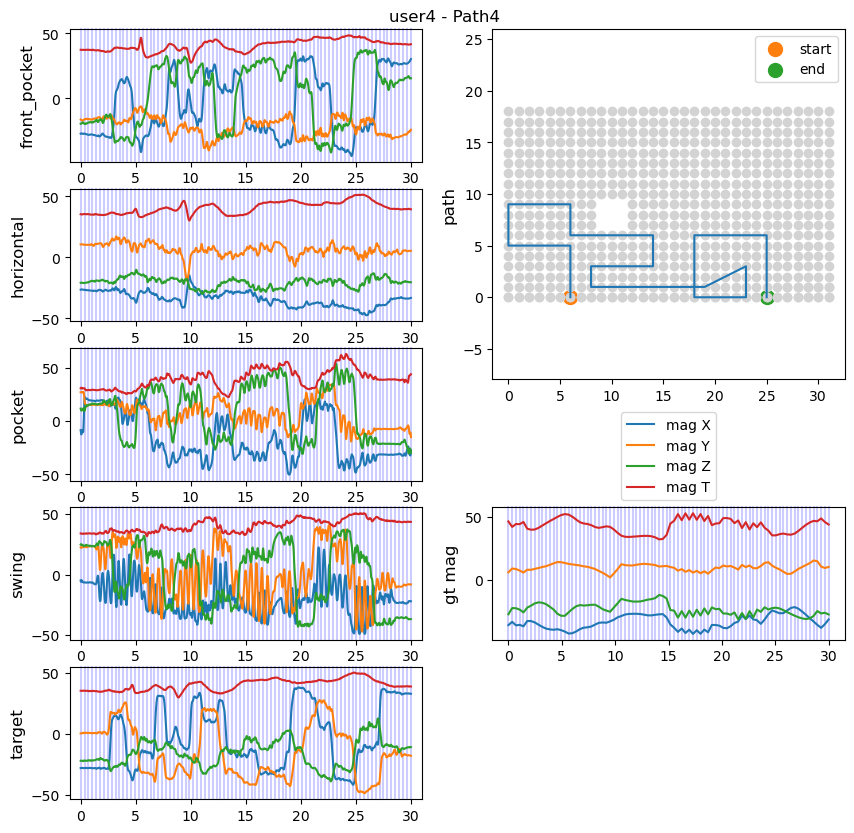

[ 31  30  29  28  27  58  89 120 151 182 213 244 243 242 241 240 239 238
 237 268 299 330 310 291 271 252 233 264 295 326 308 290 272 254 237 206
 175 144 113  82  83  84  85  86  87  88  89  90  91  92  93]


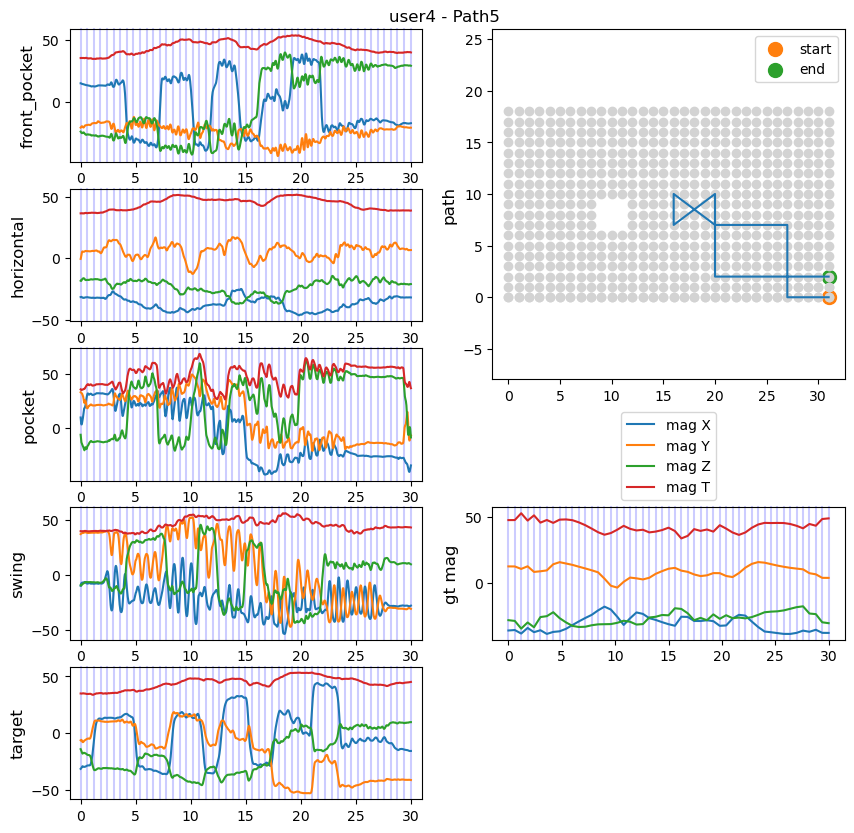

In [12]:
all_user_match_data = defaultdict(defaultdict)

for user_name in all_data.keys():
    for path_name in all_data[user_name].keys():
        plt.figure(figsize=(10, 10))
        all_user_match_data[user_name][path_name] = defaultdict()
        
        for i, posture_name in enumerate(all_data[user_name][path_name].keys()):
            data = all_data[user_name][path_name][posture_name]
            path_point = np.array(user_path[user_name][path_name])
            
            time = data[:, 0] - data[:, 0][0]
            time = time / np.max(time) * 30
            
            ### plot posture mag
            plt.subplot(5, 2, 2 * (i + 1) - 1)
            plt.plot(time, data[:, 10])
            plt.plot(time, data[:, 11])
            plt.plot(time, data[:, 12])
            plt.plot(time, data[:, 13])

            plt.xlim([-1, 31])
            plt.ylabel(posture_name.split('/')[-1], fontsize=12)

            split_index = [i / (len(path_point) - 1) * (len(data) - 1) for i in range((len(path_point)))]
            split_index = np.round(split_index).astype(int)
            
            all_user_match_data[user_name][path_name][posture_name] = np.concatenate((path_point, data[split_index]), axis=-1)
            
            for idx in split_index:
                x = idx / len(data) * 30
                plt.axvline(x=x, ymin=0, ymax=1, c='blue', zorder=0, clip_on=False, alpha=0.2)
        
        ### plot path
        plt.subplot(2, 2, 2)
        plt.plot(path_point[:, 1], path_point[:, 0])
        plt.scatter(path_point[0, 1], path_point[0, 0], s=100, c='tab:orange', label='start')
        plt.scatter(path_point[-1, 1], path_point[-1, 0], s=100, c='tab:green', label='end')
        plt.scatter(grid_data[:, 1], grid_data[:, 0], color='lightgray')
#         plt.gca().invert_yaxis()
        plt.legend()
        plt.ylabel(f'path', fontsize=12)
        plt.axis('equal')
        
        ### plot gt mag
        plt.subplot(5, 2, 8)
        idx = path_point[:, 1] + path_point[:, 0] * 31
        idx = idx.astype(int)
        mag = grid_data[idx]
        time = [i / (len(idx) - 1) * (30) for i in range((len(idx)))]
        print(idx)
        
#         plt.plot(time, mag[:, 2], label='mag X')
#         plt.plot(time, mag[:, 3], label='mag Y')
#         plt.plot(time, mag[:, 4], label='mag Z')
#         plt.plot(time, np.sqrt(np.sum(np.power(mag[:, 2:5], 2), axis=-1)), label='mag T')

        plt.plot(time, moving_average(mag[:, 2], 3), label='mag X')
        plt.plot(time, moving_average(mag[:, 3], 3), label='mag Y')
        plt.plot(time, moving_average(mag[:, 4], 3), label='mag Z')
        plt.plot(time, moving_average(np.sqrt(np.sum(np.power(mag[:, 2:5], 2), axis=-1)), 3), label='mag T')

        plt.ylabel(f'gt mag', fontsize=12)
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
        
        for x in time:
            plt.axvline(x=x, ymin=0, ymax=1, c='blue', zorder=0, clip_on=False, alpha=0.2)
        
        # plt.axvline(x=0, ymin=-0.2, ymax=1, c='red', zorder=0, clip_on=False)
        plt.suptitle(f'{user_name} - {path_name}', x=0.5, y=0.9)
        plt.show()

In [10]:
np.save('kalman/all_user_match_data', all_user_match_data)